# Введение в прект



Набор исследуемых данных является временным рядом.


---


*Сразу скажу, что пока плохо поняла работу с временными рядами, поэтому в основном взяла код и подход из [статьи](https://habr.com/ru/companies/ods/articles/327242/), так подход в ней покзаался мне наибоее приближенным к задачам курса.*

*На данном этапе я встретила много сложных моментов, не понятных мне, на которые хотела бы получить ответ в результате проверки заданая, так что рассчитываю больше на критику, чем на оценку выше 0)*

*В связи с этим взяла на себя смелосить добавить много персональных комментариев.*


---

Для работы был взят набор данных представляющий собой статистику посещения пользователями библиотеки ЛитРес ИТМО за последние 3 года (2021 - 2023).

Цель работы — предсказать активность пользователей на 2024 год.


 # Визуализация данных

Ниже приведен код для визуализации данных. Уже на этом этапе я встретила интересную ошибку, почему-то не отображается график по предложенному в статье коду, так что ниже приведен другой.

<Axes: title={'center': 'Статистика посещения'}, xlabel='Дата'>

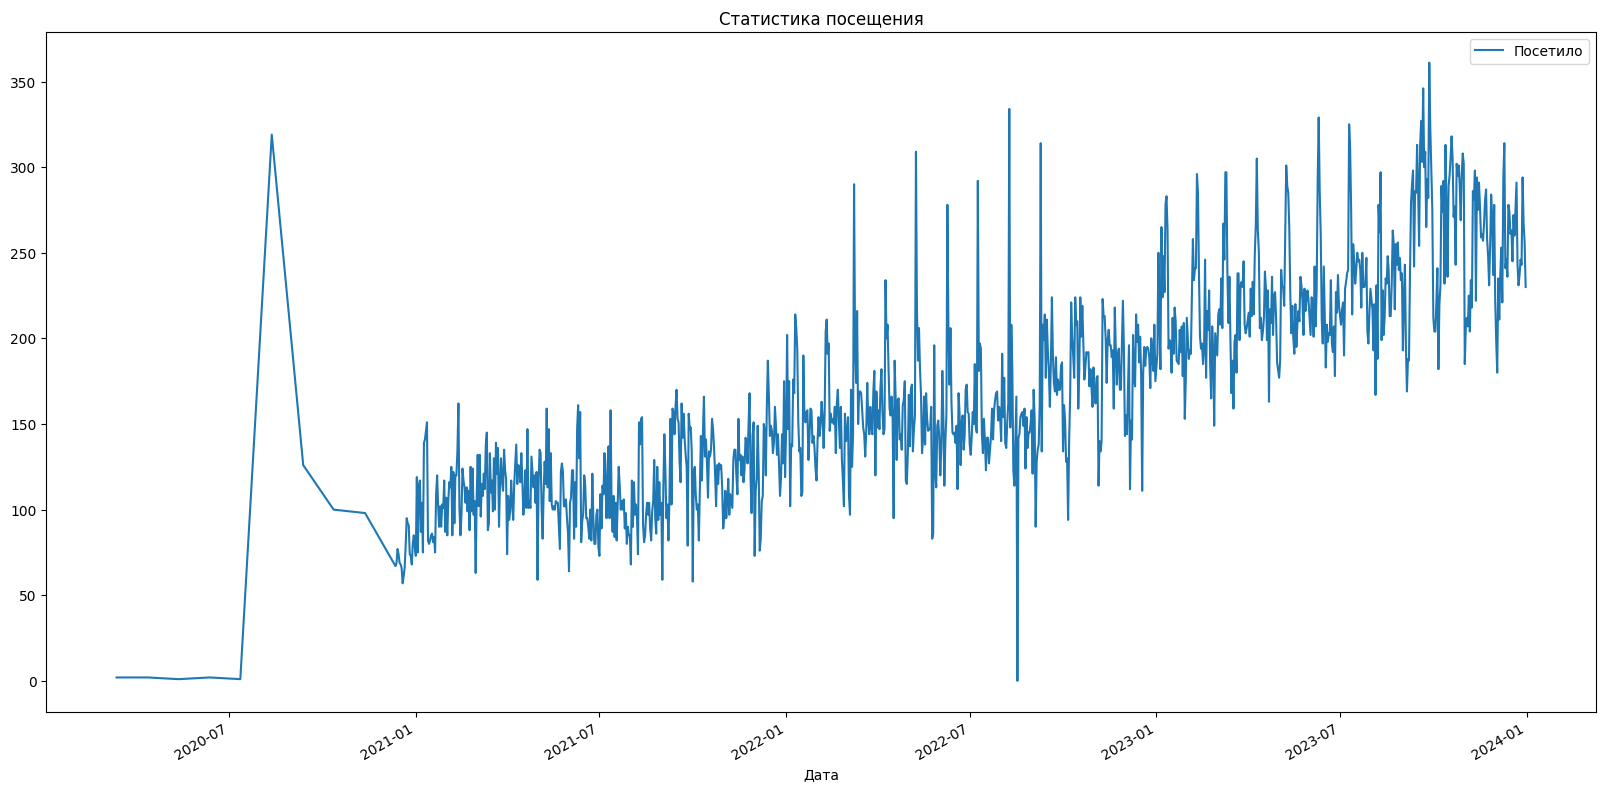

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

#data = pd.read_excel('Общая2.xlsx', index_col=False, parse_dates=['Дата'])
dataset = pd.read_csv('Общая2.csv', delimiter=';', index_col='Дата', parse_dates=['Дата'])

#dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Статистика посещения")
dataset.plot(figsize=(20,10), title = "Статистика посещения")


Можно видеть, что на старте запуска сервиса наблюдается небывалый скачок посещений, что, очевидно, связано с интересом в сервису в момент его запуска. Стоит ли сохранять такие данные или лучше удалить, для повышения точности модели? На мой взгляд они вносят лишние не объективные значения.

# Rolling window estimations

Рассмотрим данные при помощи скользящего среднего значения.

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Посетило, 24)

253.04166666666666

Попробуем сгладить изначальные данные при помощи скользящей средней.

Но на моих данных почему-то метод из статьи показывает какой-то безумный тренд, не могу понять с чем это связано, когда записываю визуализацию сама, всё выглядит отлично.

Не до конца понимаю выбор авторами 24 часов как первой рамки, так как кажется их исходные данные содержат информацию по одному дню, а не по каждому часу. Пока оставила для своих данных такие же параметры, просто что бы даже сравнить построение графиков, но возможно мне стоит n принимиать как 7 и 30, то есть неделю и месяц.



In [ ]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

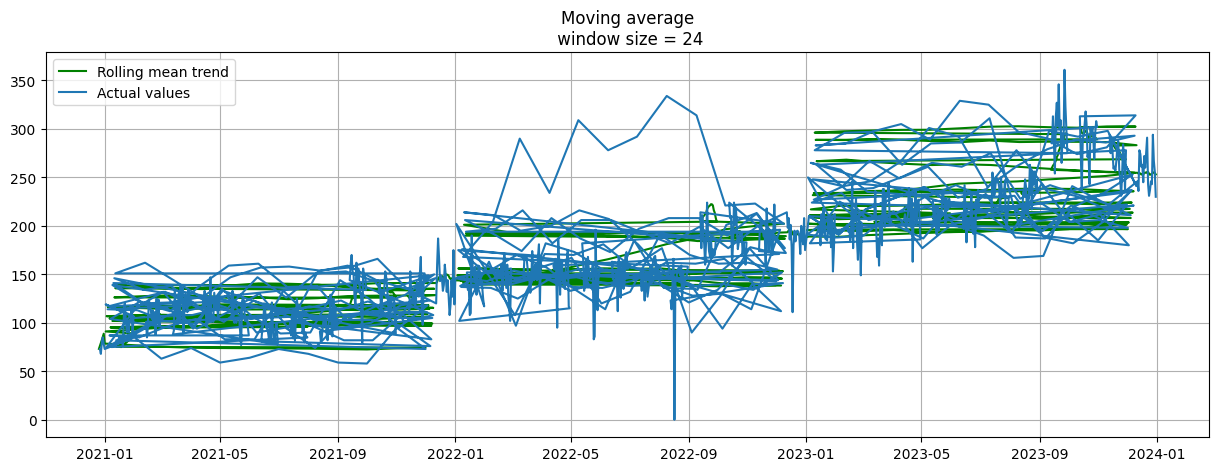

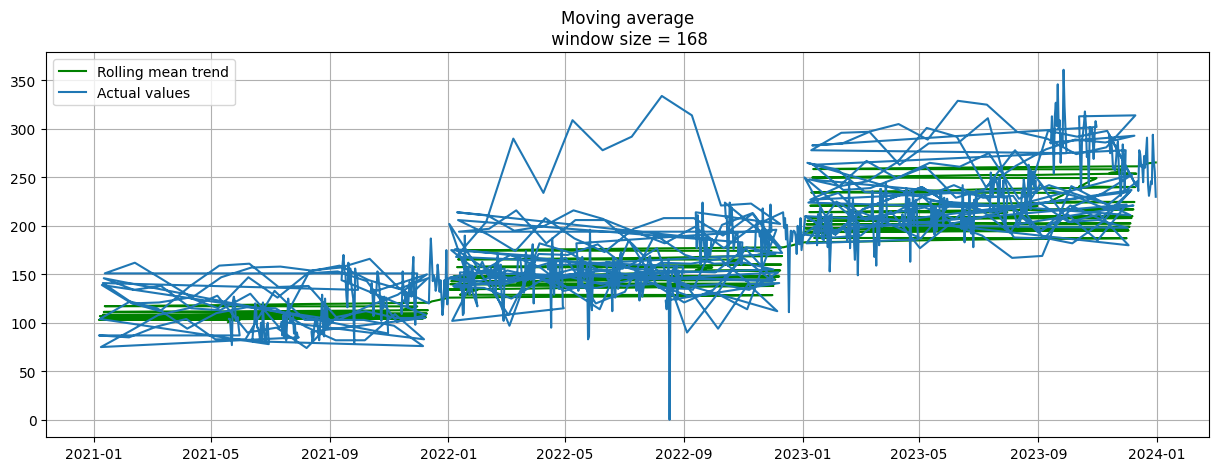

In [ ]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

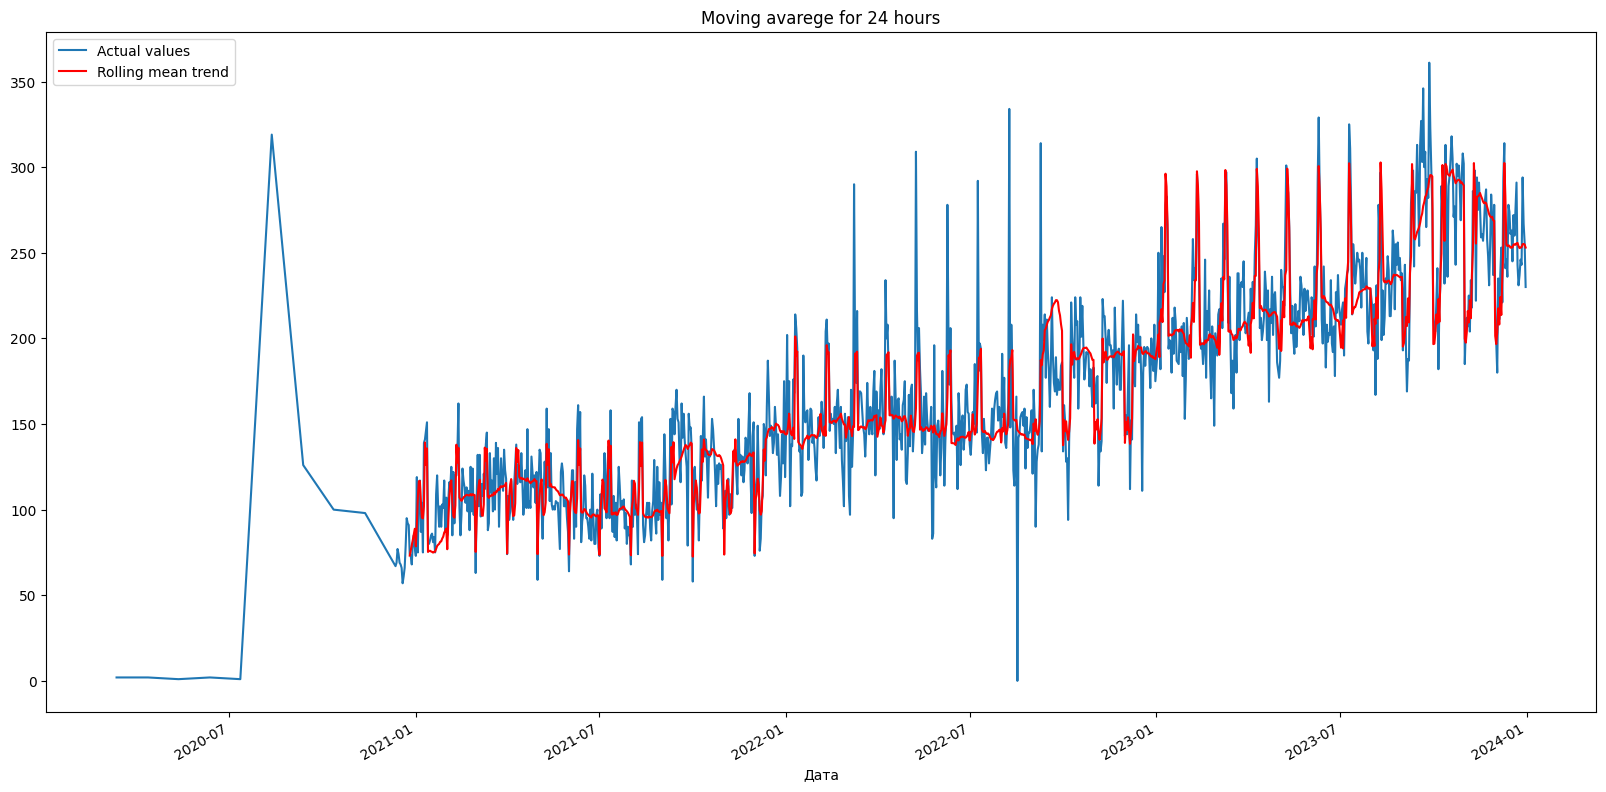

In [ ]:
rolling_mean = dataset.rolling(window=24).mean()

ax = dataset.plot(figsize=(20,10), title = "Moving avarege for 24 hours")
rolling_mean.plot(color='red', ax = ax)
plt.legend(('Actual values', 'Rolling mean trend'))


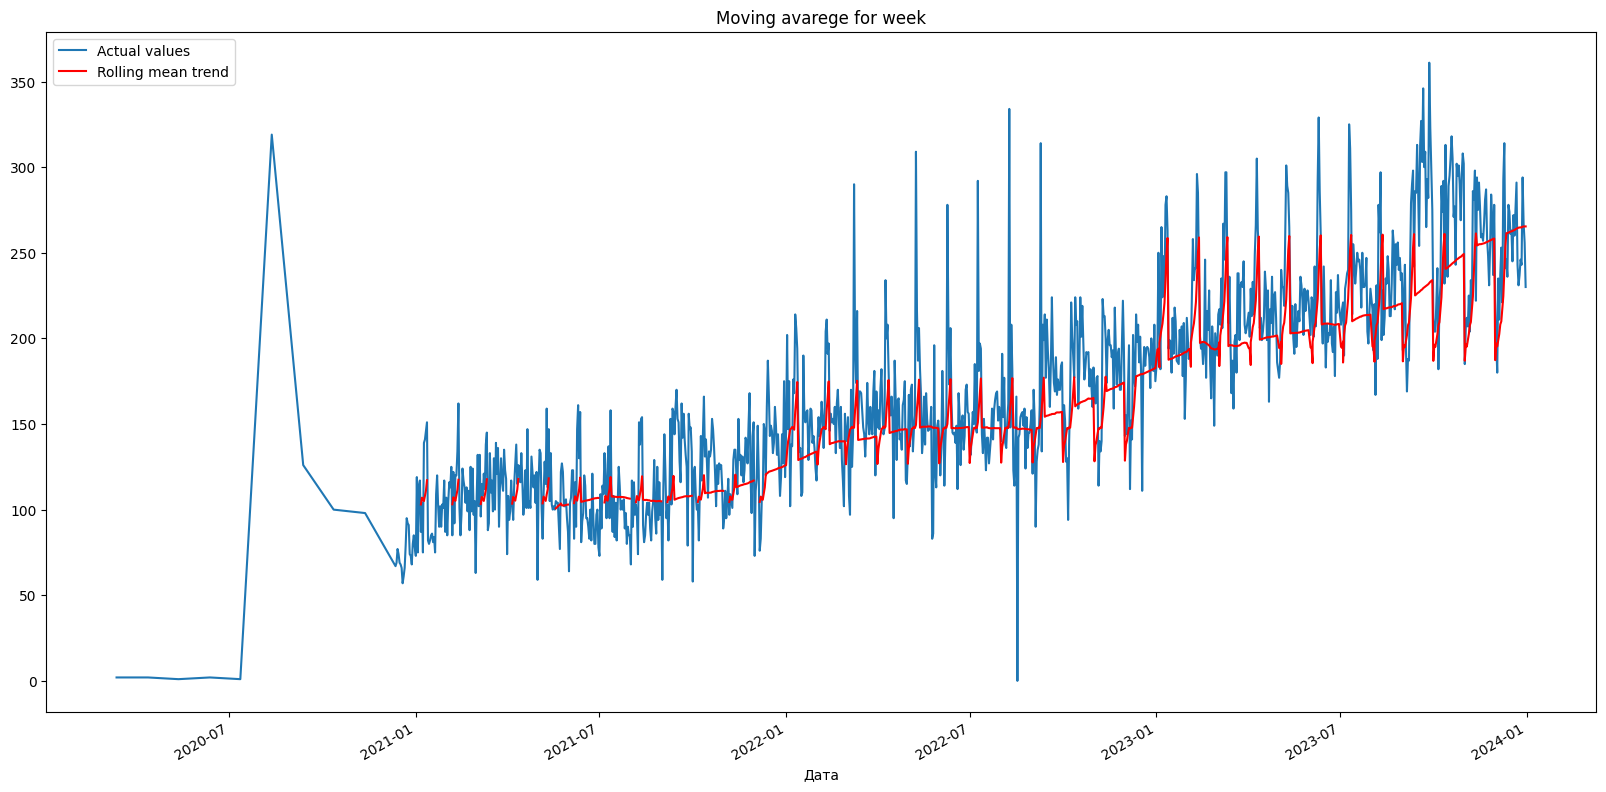

In [ ]:
rolling_mean = dataset.rolling(window=24*7).mean()

ax = dataset.plot(figsize=(20,10), title = "Moving avarege for week")
rolling_mean.plot(color='red', ax = ax)
plt.legend(('Actual values', 'Rolling mean trend'))

# Расчет взвещенного среднего

In [ ]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Посетило, [0.6, 0.2, 0.1, 0.07, 0.03])

256.12

# EMA

Оценим модель по методу экспоненциального сглаживания, выбор значения α оставлю за авторами статьи. В этом случае вроде всё хорошо отображается, так что свои визуалтзации не прикладываю.

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

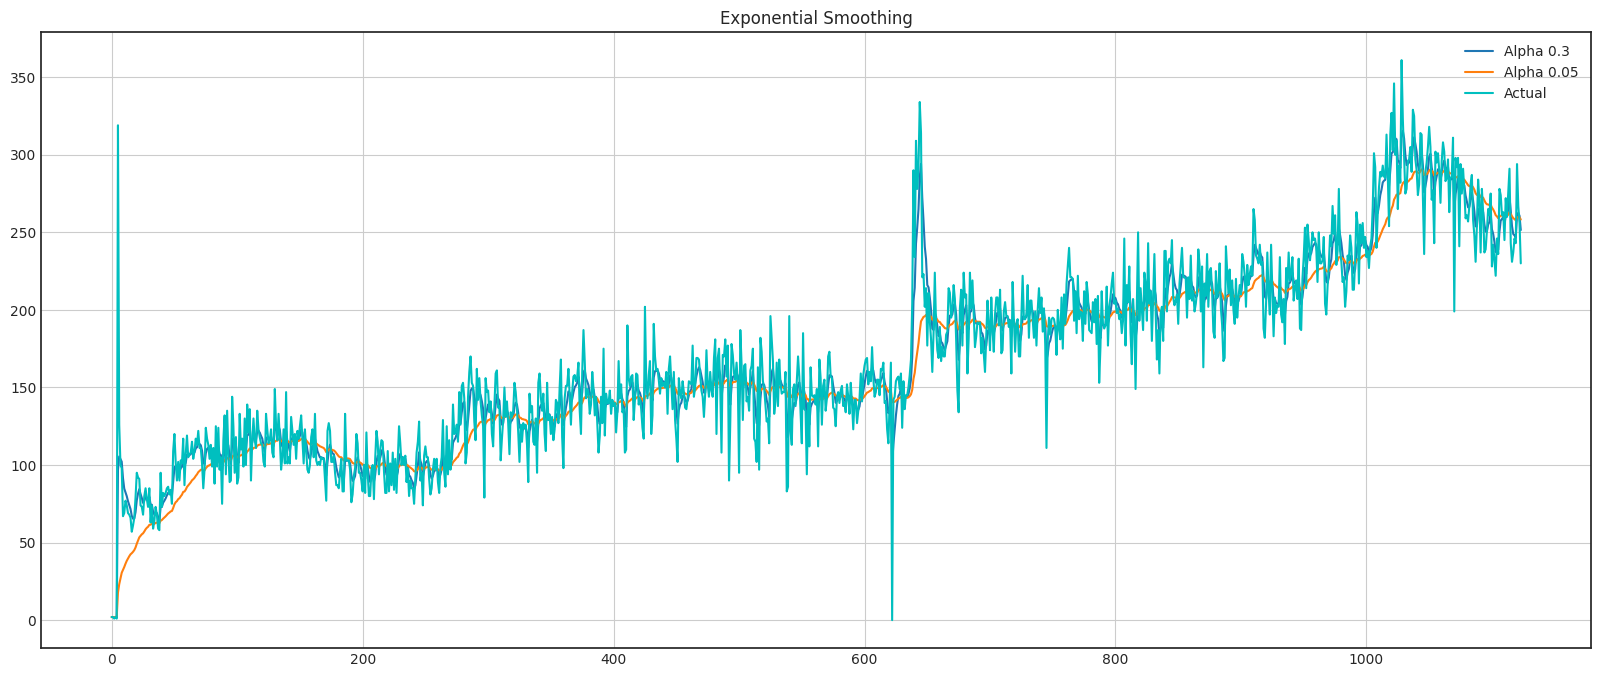

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Посетило, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Посетило.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Двойное экспоненциальное сглаживание

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

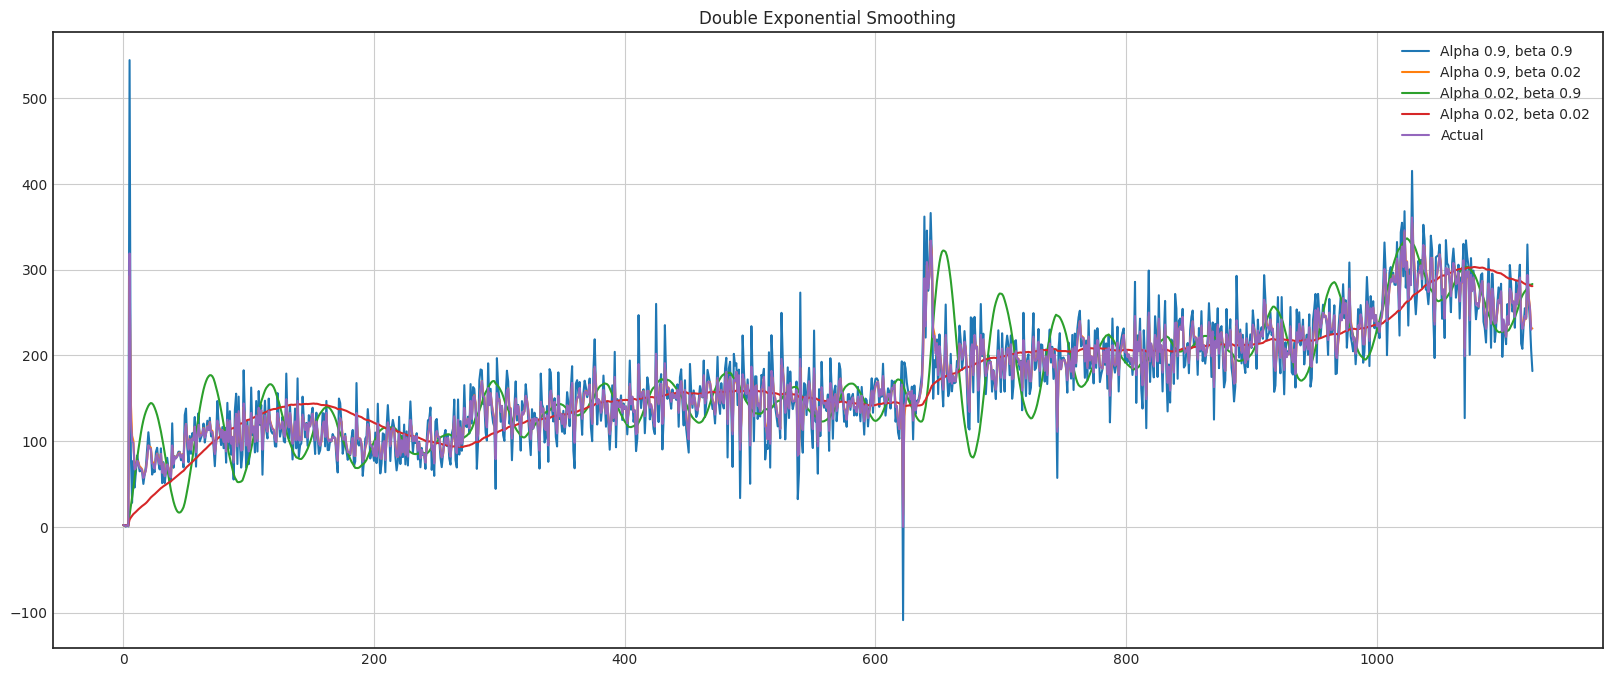

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Посетило, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Посетило.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# Holt-Winters (тройное экспоненциальное сглаживание)

In [ ]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

# Кросс-валидация на временном ряду

В этом блоке у меня возникает ошибка в коде, которая возникает в программе непосредственно авторов статьи, я посмотрела куда она закралась, но не понимаю почему она там возникает. Ошибка индексов в классе выше.

In [1]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors))

In [ ]:
%%time
data = dataset.Посетило[:-10] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

IndexError: index 280 is out of bounds for axis 0 with size 280